# Gaussian Blur with Cuda Bindings

## 1. The 2D Gaussian Function

The Gaussian function (bell curve) in 2D is defined as:

$$G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

Where:
- $x, y$ are the coordinates relative to the center of the kernel
- $\sigma$ (sigma) is the standard deviation, controlling the spread/width
- $e$ is Euler's number ($\approx 2.71828$)

## 2. Standard Deviation ($\sigma$) Effect

The parameter $\sigma$ controls the blur strength:

- **Small $\sigma$ (0.5-1.0)**: Narrow bell curve → subtle blur
- **Large $\sigma$ (3.0-5.0)**: Wide bell curve → strong blur

The variance is $\sigma^2$, and roughly 95% of the weight is within $2\sigma$ from the center.

## 3. Creating a Discrete Kernel

For a kernel of size $n \times n$ (e.g., $5 \times 5$), we:

1. Create a grid of coordinates centered at $(0, 0)$:
   $$\text{For } n=5: \quad x, y \in \{-2, -1, 0, 1, 2\}$$

2. Evaluate $G(x, y)$ at each grid point:
   $$K[i][j] = G(x_i, y_j) = \frac{1}{2\pi\sigma^2} e^{-\frac{x_i^2 + y_j^2}{2\sigma^2}}$$

3. Normalize so the sum equals 1:
   $$K_{\text{normalized}}[i][j] = \frac{K[i][j]}{\sum_{m,n} K[m][n]}$$

In [22]:
from cuda.bindings import driver, nvrtc
import numpy as np
from PIL import Image
from PIL import ImageDraw


def checkCudaErrors(result):
    if result[0].value:
        raise RuntimeError(f"CUDA error {result[0]}")
    return result[1] if len(result) == 2 else (result[1:]) if len(result) > 2 else None


def generate_gaussian_kernel_code(kernel_size, sigma):
    # Create Gaussian kernel
    ax = np.arange(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))

    # Scale to integers for better precision in GPU
    scale_factor = 1000
    kernel_int = np.round(kernel * scale_factor).astype(int)
    print(f"Kernel: {kernel_int}")
    kernel_sum = kernel_int.sum()
    print(f"Kernel Sum: {kernel_sum}")

    # Generate kernel array as C++ string
    kernel_str = "{\n"
    for row in kernel_int:
        kernel_str += "        {" + ", ".join(map(str, row)) + "},\n"
    kernel_str += "    }"

    # Generate CUDA code
    offset = kernel_size // 2

    code = f"""
extern "C" __global__
void gaussian_blur(const unsigned char* input, 
                   unsigned char* output,
                   int width, int height, int channels)
{{
    // Calculate 2D pixel position
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    if (x >= width || y >= height) return;
    
    // {kernel_size}x{kernel_size} Gaussian kernel (sigma={sigma})
    const float kernel[{kernel_size}][{kernel_size}] = {kernel_str};
    const float kernel_sum = {kernel_sum}.0f;
    
    // Process each channel (grayscale=1, RGB=3, RGBA=4)
    for (int c = 0; c < channels; c++) {{
        float sum = 0.0f;
        
        // Apply convolution: weighted sum of neighbors
        for (int ky = 0; ky < {kernel_size}; ky++) {{
            for (int kx = 0; kx < {kernel_size}; kx++) {{
                // Calculate neighbor position
                int nx = x + kx - {offset};
                int ny = y + ky - {offset};
                
                // Clamp to image edges
                nx = max(0, min(nx, width - 1));
                ny = max(0, min(ny, height - 1));
                
                // Accumulate weighted pixel value
                int idx = (ny * width + nx) * channels + c;
                sum += input[idx] * kernel[ky][kx];
            }}
        }}
        
        // Write normalized result
        int out_idx = (y * width + x) * channels + c;
        output[out_idx] = (unsigned char)(sum / kernel_sum);
    }}
}}
"""
    return code


generate_gaussian_kernel_code(7, 1.5)

Kernel: [[  18   56  108  135  108   56   18]
 [  56  169  329  411  329  169   56]
 [ 108  329  641  801  641  329  108]
 [ 135  411  801 1000  801  411  135]
 [ 108  329  641  801  641  329  108]
 [  56  169  329  411  329  169   56]
 [  18   56  108  135  108   56   18]]
Kernel Sum: 13644


'\nextern "C" __global__\nvoid gaussian_blur(const unsigned char* input, \n                   unsigned char* output,\n                   int width, int height, int channels)\n{\n    // Calculate 2D pixel position\n    int x = blockIdx.x * blockDim.x + threadIdx.x;\n    int y = blockIdx.y * blockDim.y + threadIdx.y;\n\n    if (x >= width || y >= height) return;\n\n    // 7x7 Gaussian kernel (sigma=1.5)\n    const float kernel[7][7] = {\n        {18, 56, 108, 135, 108, 56, 18},\n        {56, 169, 329, 411, 329, 169, 56},\n        {108, 329, 641, 801, 641, 329, 108},\n        {135, 411, 801, 1000, 801, 411, 135},\n        {108, 329, 641, 801, 641, 329, 108},\n        {56, 169, 329, 411, 329, 169, 56},\n        {18, 56, 108, 135, 108, 56, 18},\n    };\n    const float kernel_sum = 13644.0f;\n\n    // Process each channel (grayscale=1, RGB=3, RGBA=4)\n    for (int c = 0; c < channels; c++) {\n        float sum = 0.0f;\n\n        // Apply convolution: weighted sum of neighbors\n        for (

## Generated String

After running the code block above your string should look like this C++ code

```c++
extern "C" __global__
void gaussian_blur(const unsigned char* input, 
                   unsigned char* output,
                   int width, int height, int channels)
{
    // Calculate 2D pixel position
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // 7x7 Gaussian kernel (sigma=1.5)
    const float kernel[7][7] = {
        {18, 56, 108, 135, 108, 56, 18},
        {56, 169, 329, 411, 329, 169, 56},
        {108, 329, 641, 801, 641, 329, 108},
        {135, 411, 801, 1000, 801, 411, 135},
        {108, 329, 641, 801, 641, 329, 108},
        {56, 169, 329, 411, 329, 169, 56},
        {18, 56, 108, 135, 108, 56, 18},
    };
    const float kernel_sum = 13644.0f;

    // Process each channel (grayscale=1, RGB=3, RGBA=4)
    for (int c = 0; c < channels; c++) {
        float sum = 0.0f;

        // Apply convolution: weighted sum of neighbors
        for (int ky = 0; ky < 7; ky++) {
            for (int kx = 0; kx < 7; kx++) {
                // Calculate neighbor position
                int nx = x + kx - 3;
                int ny = y + ky - 3;

                // Clamp to image edges
                nx = max(0, min(nx, width - 1));
                ny = max(0, min(ny, height - 1));

                // Accumulate weighted pixel value
                int idx = (ny * width + nx) * channels + c;
                sum += input[idx] * kernel[ky][kx];
            }
        }

        // Write normalized result
        int out_idx = (y * width + x) * channels + c;
        output[out_idx] = (unsigned char)(sum / kernel_sum);
    }
}
```

## Explaining the Code

```c++
int x = blockIdx.x * blockDim.x + threadIdx.x;
int y = blockIdx.y * blockDim.y + threadIdx.y;
```

GPUs group cores into streaming multiprocessors. For my GPU (5090 RTX) the blocks look like

```ascii
NVIDIA RTX 5090 (Blackwell - GB202)
════════════════════════════════════════════════════════════════════════════

┌──────────────────────────────────────────────────────────────────────────┐
│                         170 Streaming Multiprocessors                    │
│                         21,760 CUDA Cores Total                          │
└──────────────────────────────────────────────────────────────────────────┘

 SM0   SM1   SM2   SM3   SM4   SM5   SM6   SM7   SM8   SM9   SM10  SM11
┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐
│128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│
└───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘
                                ...
                      (146 more SMs in middle)
                                ...
SM158 SM159 SM160 SM161 SM162 SM163 SM164 SM165 SM166 SM167 SM168 SM169
┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐
│128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│
└───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘

Each SM: 128 CUDA cores + 4 Tensor Cores + 1 RT Core
────────────────────────────────────────────────────────────────────────────
```

x and y are computing the following

```python
x = (which block) × (block size) + (position in block)
y = (which block) × (block size) + (position in block)
```

### Threading per Pixel

Another way to view this is that each thread computes the blur for one pixel. Let's look at this example

```ascii
800×600 IMAGE DIVIDED FOR GPU
═══════════════════════════════════════════════════════════════

STEP 1: Choose Block Size
──────────────────────────
BLOCK_SIZE_X = 16 threads
BLOCK_SIZE_Y = 16 threads
Each block = 16×16 = 256 threads (256 pixels)


STEP 2: Calculate Grid Size
────────────────────────────
GRID_SIZE_X = 800 ÷ 16 = 50 blocks wide
GRID_SIZE_Y = 600 ÷ 16 = 38 blocks tall
Total = 50 × 38 = 1,900 blocks


STEP 3: Image Divided into Grid of Blocks
──────────────────────────────────────────

         50 blocks wide →
    ┌───┬───┬───┬───┬───┬───┬───┐
    │0,0│1,0│2,0│3,0│4,0│...│49,0│  ← Row 0 (38 rows total)
    ├───┼───┼───┼───┼───┼───┼───┤
38  │0,1│1,1│2,1│3,1│4,1│...│49,1│  ← Row 1
    ├───┼───┼───┼───┼───┼───┼───┤  ↓
b   │0,2│1,2│2,2│3,2│4,2│...│49,2│
l   ├───┼───┼───┼───┼───┼───┼───┤
o   │ ⋮ │ ⋮ │ ⋮ │ ⋮ │ ⋮ │ ⋮ │ ⋮ │
c   ├───┼───┼───┼───┼───┼───┼───┤
k   │0,37│1,37│...│     │   │49,37│ ← Row 37
s   └───┴───┴───┴───┴───┴───┴───┘


STEP 4: Each Block Contains 16×16 Threads
──────────────────────────────────────────

Zoom into Block(5,3):
                         16 threads wide →
    ┌──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┐
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ ← Row 0
    ├──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┤
16  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    ├──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┤  ↓
t   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
h   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
r   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
e   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
a   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
d   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
s   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │🔲│ │  │  │  │  │  │  │  │ ← Row 12
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    └──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┘
                           ↑
                      Thread(7,12)
                      
Each cell = 1 thread = 1 pixel


STEP 5: Thread Calculates Its Pixel
────────────────────────────────────

Thread(7,12) in Block(5,3):

x = blockIdx.x × blockDim.x + threadIdx.x
  = 5 × 16 + 7 = 87 (column)

y = blockIdx.y × blockDim.y + threadIdx.y
  = 3 × 16 + 12 = 60 (row)

This thread processes pixel (87, 60) ✓


SUMMARY
═══════════════════════════════════════════════════════════════
Image:     800 × 600 = 480,000 pixels
Grid:      50 × 38 = 1,900 blocks
Block:     16 × 16 = 256 threads
Total:     1,900 × 256 = 486,400 threads
```

### Summary

X and Y are calculating the column and row for the thread process

**`x` = Which pixel COLUMN this thread processes**

**`y` = Which pixel ROW this thread processes**


## Explaining the Convolutions

```c
int nx = x + kx - 3;
int ny = y + ky - 3;
```
this centers the kernel

Example: If current pixel is at (100, 100):

When kx=0, ky=0 → neighbor at (97, 97) — top-left of kernel
When kx=3, ky=3 → neighbor at (100, 100) — center (current pixel)
When kx=6, ky=6 → neighbor at (103, 103) — bottom-right of kernel

The -3 offset centers the kernel (since kernel_size // 2 = 7 // 2 = 3)

```c
nx = max(0, min(nx, width - 1));
ny = max(0, min(ny, height - 1));
```

Handles edge cases of negative positions


```c
int idx = (ny * width + nx) * channels + c;
```

converts 2D image coordinates + channel into a 1D array index\

```c
// Write normalized result
int out_idx = (y * width + x) * channels + c;
output[out_idx] = (unsigned char)(sum / kernel_sum);
```

calculates where to write the blurred pixel for the output array
This will normalize the values back to 0-255


```c
// 7x7 Gaussian kernel (sigma=1.5)
const float kernel[7][7] = {
    {18, 56, 108, 135, 108, 56, 18},
    {56, 169, 329, 411, 329, 169, 56},
    {108, 329, 641, 801, 641, 329, 108},
    {135, 411, 801, 1000, 801, 411, 135},
    {108, 329, 641, 801, 641, 329, 108},
    {56, 169, 329, 411, 329, 169, 56},
    {18, 56, 108, 135, 108, 56, 18},
};
const float kernel_sum = 13644.0f;
```

The reason that these are integer looking floats (These are floats without the fraction) is so the scaling of the numbers work out to be easier to read and process. Small floats overtime will lose precision.

## Performing the Gaussian Blur

In [23]:
def gaussian_blur_cuda(img_array, kernel_size=7, sigma=1.5):
    """
    Apply Gaussian blur to image using CUDA bindings
    
    Args:
        img_array: NumPy array of image (H, W) or (H, W, C)
        kernel_size: Size of Gaussian kernel (must be odd)
        sigma: Blur strength (higher = more blur)
        
    Returns:
        Blurred image as NumPy array
    """
    
    # Handle image dimensions
    if len(img_array.shape) == 2:
        # Grayscale - add channel dimension
        img_array = img_array[:, :, np.newaxis]
        channels = 1
    else:
        channels = img_array.shape[2]
    
    height, width = img_array.shape[:2]
    
    print(f"\n{'='*60}")
    print(f"Gaussian Blur Settings")
    print(f"{'='*60}")
    print(f"  Image size: {width} × {height} pixels")
    print(f"  Channels: {channels}")
    print(f"  Kernel: {kernel_size}×{kernel_size}, σ={sigma}")
    
    # ============================================================
    # Step 1: Initialize CUDA
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 1: Initialize CUDA")
    print(f"{'='*60}")
    
    checkCudaErrors(driver.cuInit(0))
    device = checkCudaErrors(driver.cuDeviceGet(0))
    
    # Get device info
    device_name = checkCudaErrors(driver.cuDeviceGetName(256, device))
    major = checkCudaErrors(driver.cuDeviceGetAttribute(
        driver.CUdevice_attribute.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MAJOR, device))
    minor = checkCudaErrors(driver.cuDeviceGetAttribute(
        driver.CUdevice_attribute.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MINOR, device))
    
    print(f"  ✓ Device: {device_name.decode()}")
    print(f"  ✓ Compute Capability: {major}.{minor}")
    
    # ============================================================
    # Step 2: Compile CUDA Kernel
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 2: Compile CUDA Kernel")
    print(f"{'='*60}")
    
    kernel_code = generate_gaussian_kernel_code(kernel_size, sigma)
    
    prog = checkCudaErrors(nvrtc.nvrtcCreateProgram(
        kernel_code.encode(), b"gaussian_blur.cu", 0, [], []))
    
    arch_arg = f'--gpu-architecture=compute_{major}{minor}'.encode()
    checkCudaErrors(nvrtc.nvrtcCompileProgram(prog, 1, [arch_arg]))
    
    ptx_size = checkCudaErrors(nvrtc.nvrtcGetPTXSize(prog))
    ptx = b" " * ptx_size
    checkCudaErrors(nvrtc.nvrtcGetPTX(prog, ptx))
    
    print(f"  ✓ Kernel compiled successfully")
    
    # ============================================================
    # Step 3: Load Module and Get Kernel Function
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 3: Load Module")
    print(f"{'='*60}")
    
    context = checkCudaErrors(driver.cuCtxCreate(0, device))
    ptx_data = np.char.array(ptx)
    module = checkCudaErrors(driver.cuModuleLoadData(ptx_data.ctypes.data))
    kernel = checkCudaErrors(driver.cuModuleGetFunction(module, b"gaussian_blur"))
    
    print(f"  ✓ Module loaded")
    
    # ============================================================
    # Step 4: Allocate GPU Memory
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 4: Allocate GPU Memory")
    print(f"{'='*60}")
    
    buffer_size = width * height * channels
    d_input = checkCudaErrors(driver.cuMemAlloc(buffer_size))
    d_output = checkCudaErrors(driver.cuMemAlloc(buffer_size))
    
    print(f"  ✓ Allocated {buffer_size:,} bytes on GPU")
    
    # ============================================================
    # Step 5: Transfer Data to GPU
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 5: Transfer Data to GPU")
    print(f"{'='*60}")
    
    stream = checkCudaErrors(driver.cuStreamCreate(0))
    checkCudaErrors(driver.cuMemcpyHtoDAsync(
        d_input, img_array.ctypes.data, buffer_size, stream))
    
    print(f"  ✓ Data transferred")
    
    # ============================================================
    # Step 6: Configure and Launch Kernel
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 6: Launch Kernel")
    print(f"{'='*60}")
    
    # 2D grid configuration
    BLOCK_SIZE_X = 16
    BLOCK_SIZE_Y = 16
    GRID_SIZE_X = (width + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X
    GRID_SIZE_Y = (height + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y
    
    print(f"  Grid:  {GRID_SIZE_X} × {GRID_SIZE_Y} blocks")
    print(f"  Block: {BLOCK_SIZE_X} × {BLOCK_SIZE_Y} threads")
    print(f"  Total: {GRID_SIZE_X * GRID_SIZE_Y * BLOCK_SIZE_X * BLOCK_SIZE_Y:,} threads")
    
    # Prepare kernel arguments
    args_data = [
        np.array([int(d_input)], dtype=np.uint64),
        np.array([int(d_output)], dtype=np.uint64),
        np.array([width], dtype=np.int32),
        np.array([height], dtype=np.int32),
        np.array([channels], dtype=np.int32)
    ]
    args = np.array([arg.ctypes.data for arg in args_data], dtype=np.uint64)
    
    # Launch!
    checkCudaErrors(driver.cuLaunchKernel(
        kernel,
        GRID_SIZE_X, GRID_SIZE_Y, 1,     # 2D grid
        BLOCK_SIZE_X, BLOCK_SIZE_Y, 1,   # 2D blocks
        0, stream, args.ctypes.data, 0
    ))
    
    print(f"  ✓ Kernel launched")
    
    # ============================================================
    # Step 7: Copy Result Back
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 7: Copy Result from GPU")
    print(f"{'='*60}")
    
    output_array = np.empty_like(img_array)
    checkCudaErrors(driver.cuMemcpyDtoHAsync(
        output_array.ctypes.data, d_output, buffer_size, stream))
    checkCudaErrors(driver.cuStreamSynchronize(stream))
    
    print(f"  ✓ Blur complete!")
    
    # ============================================================
    # Step 8: Cleanup
    # ============================================================
    checkCudaErrors(driver.cuStreamDestroy(stream))
    checkCudaErrors(driver.cuMemFree(d_input))
    checkCudaErrors(driver.cuMemFree(d_output))
    checkCudaErrors(driver.cuModuleUnload(module))
    checkCudaErrors(driver.cuCtxDestroy(context))
    
    # Remove channel dimension if grayscale
    if channels == 1:
        output_array = output_array.squeeze()
    
    return output_array


In [24]:
from matplotlib import pyplot as plt


def create_test_image():
    """Create a test image with various features"""
    img = Image.new('RGB', (800, 600))
    draw = ImageDraw.Draw(img)
    
    # Background gradient
    draw.rectangle([0, 0, 800, 600], fill=(50, 100, 150))
    
    # Colored shapes
    draw.ellipse([100, 100, 400, 400], fill=(255, 100, 100))
    draw.rectangle([450, 200, 750, 500], fill=(100, 255, 100))
    draw.polygon([(300, 450), (500, 450), (400, 550)], fill=(100, 100, 255))
    
    # High contrast elements
    draw.ellipse([200, 350, 300, 450], fill=(255, 255, 255))
    draw.rectangle([600, 100, 700, 200], fill=(0, 0, 0))
    
    return img


def display_results(original, blurred, kernel_size, sigma):
    """Display original and blurred images side by side"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Original image
    axes[0].imshow(original)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Blurred image
    axes[1].imshow(blurred)
    axes[1].set_title(f'Gaussian Blur (kernel={kernel_size}×{kernel_size}, σ={sigma})', 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()    
    plt.show()


def main():    
    print("\n" + "="*60)
    print("CUDA Gaussian Blur Demo")
    print("Using cuda.bindings only")
    print("="*60)
    
    # Create test image
    print("\nCreating test image...")
    img = create_test_image()
    print("Test image created")
    
    # Convert to numpy array
    img_array = np.array(img, dtype=np.uint8)
    
    # Apply Gaussian blur
    kernel_size = 7
    sigma = 1.5
    
    blurred_array = gaussian_blur_cuda(img_array, kernel_size, sigma)
        
    # Display results
    display_results(img_array, blurred_array, kernel_size, sigma)


CUDA Gaussian Blur Demo
Using cuda.bindings only

Creating test image...
Test image created

Gaussian Blur Settings
  Image size: 800 × 600 pixels
  Channels: 3
  Kernel: 7×7, σ=1.5

Step 1: Initialize CUDA
  ✓ Device: NVIDIA GeForce RTX 5090                                                                                                                                                                                                                                         
  ✓ Compute Capability: 12.0

Step 2: Compile CUDA Kernel
Kernel: [[  18   56  108  135  108   56   18]
 [  56  169  329  411  329  169   56]
 [ 108  329  641  801  641  329  108]
 [ 135  411  801 1000  801  411  135]
 [ 108  329  641  801  641  329  108]
 [  56  169  329  411  329  169   56]
 [  18   56  108  135  108   56   18]]
Kernel Sum: 13644
  ✓ Kernel compiled successfully

Step 3: Load Module
  ✓ Module loaded

Step 4: Allocate GPU Memory
  ✓ Allocated 1,440,000 bytes on GPU

Step 5: Transfer Data to GPU
  ✓ 

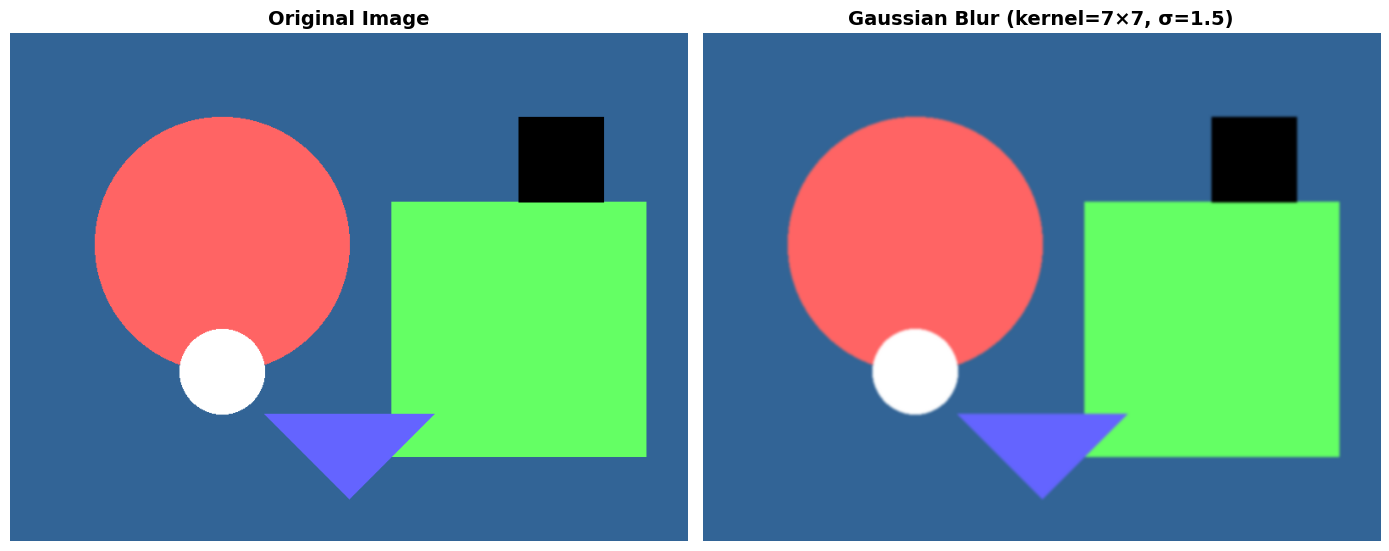

In [25]:
main()